# Demo 4: Classification with Decision tree model

This demo we will demo code for using Decision Tree model to solve the classification problem:
-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library package:
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree,...)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   pydotplus (Plot the decision tree graph)
    
Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Getting model from scikit-learn:
-   Decision Tree model
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,... 
-   Adjusting some hyperparameters to get the better model:
    -   For the criterions: Gini, Entropy,InformationGain,... <https://scikit-learn.org/stable/modules/tree.html#tree>(For references decision tree on Scikit-Learn)

## 3. Task 3: Evaluating the performance of model by Cross Validation method.
*****************************************************************************

# Import all packages


In [30]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pydotplus
from six import StringIO
from IPython.display import Image as ImageDisplay

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import pandas as pd

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [31]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [32]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [33]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 28
height = 28
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

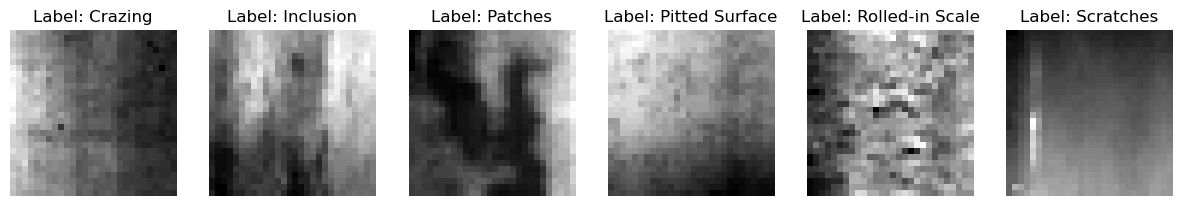

In [34]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 28 x 28 pixels. Each pixels is one feature of sample, so totally we have 28*28 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)

In [35]:
print("The currently shape of input dataset X is:", X.shape)
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))

The currently shape of input dataset X is: (1800, 28, 28)


In [36]:
print("The currently shape of input dataset X is:", X.shape)

The currently shape of input dataset X is: (1800, 784)


### 0.4. Deviding our dataset to trainset and testset

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 1440
Number of samples in the test subset: 360


## 1. Task 1: Getting model from scikit-learn

###  1.1. Getting Decision Tree model with criterion = "entropy" in scikit-learn library.

In [38]:
# Create a Tree Classification Model
tree_clf = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=24)

### 1.2. Training for our model (Fitting data to our model)

In [39]:
# Training model:
tree_clf.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=24)

### 1.3. Plot the decision tree graph after training

In [40]:
class_names = ["Cr", "In", "Pa", "PS", "RS", "Sc"]

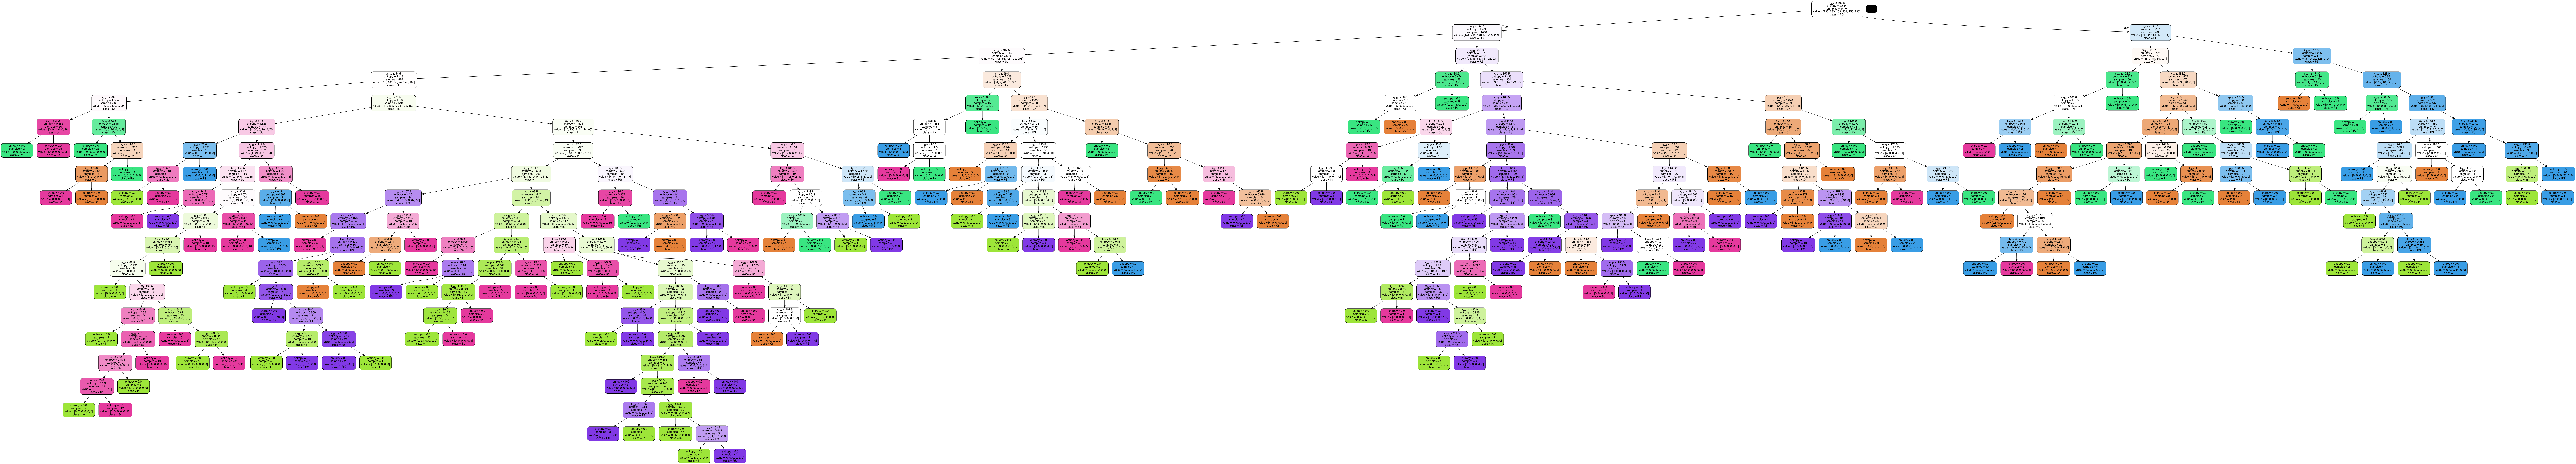

In [41]:
dot_data = StringIO()
export_graphviz(tree_clf,
                out_file=dot_data,
                filled = True,
                rounded = True,
                special_characters = True,
                class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("Tree_Classifier_Digits.png")
ImageDisplay(graph.create_png())

## 2. Task 2: Evaluating the performance of trained model on the testset
### 2.1. Predict the label (which class) for each input image in the testset


In [42]:
# Predict on test set:
pred_test = tree_clf.predict(X_test)

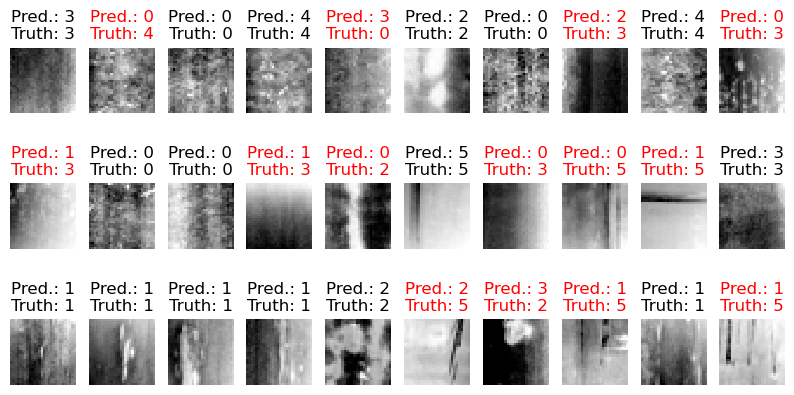

In [43]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

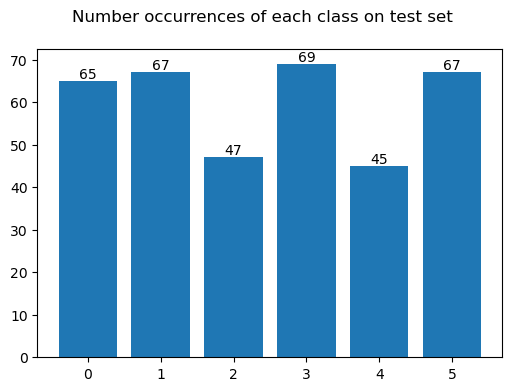

In [44]:
nb_classes = len(np.unique(y_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(y_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [45]:
# Classification report:
print(f"Classification report for classifier {tree_clf}:\n"
      f"{metrics.classification_report(y_test,pred_test,digits=4)}\n")

Classification report for classifier DecisionTreeClassifier(criterion='entropy', max_depth=24):
              precision    recall  f1-score   support

           0     0.5652    0.6000    0.5821        65
           1     0.4800    0.5373    0.5070        67
           2     0.7568    0.5957    0.6667        47
           3     0.7333    0.6377    0.6822        69
           4     0.4667    0.6222    0.5333        45
           5     0.4576    0.4030    0.4286        67

    accuracy                         0.5611       360
   macro avg     0.5766    0.5660    0.5666       360
weighted avg     0.5742    0.5611    0.5637       360




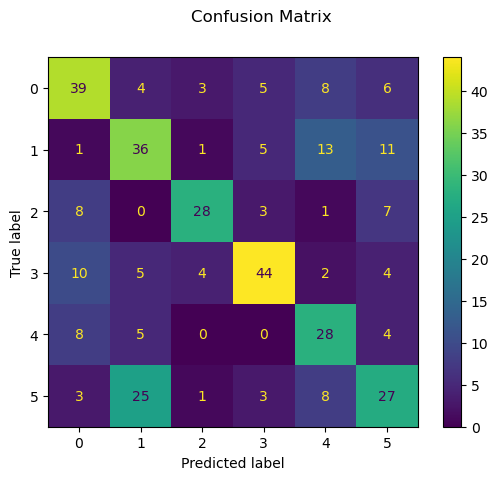

In [46]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### 2.3. Comparision of different criterias in decision tree
Splitting criteria in decision tree are used to determine how to partition the data at each notd of the tree. Three common splitting criterias: Entropy, Gini Impurity, Mean Squared Error (MSE)

In [47]:
def evaluation_model(model,
                     X_train,
                     y_train,
                     X_test,
                     y_test):
    model.fit(X_train,y_train)
    pred_test = model.predict(X_test)
    report = metrics.classification_report(y_test,pred_test,digits = 4, output_dict = True)
    return (report['macro avg'],report['weighted avg'])

In [48]:
marco_avg_all = {}
weighted_avg_all = {}
models = [DecisionTreeClassifier(criterion = "entropy",max_depth = 20),
          DecisionTreeClassifier(criterion = 'gini', max_depth = 20),
          DecisionTreeClassifier(criterion = 'log_loss', max_depth= 20)]
criterions = ["Entropy",
              "Gini",
              "Log_loss"]
for i in range(len(models)):
    result = evaluation_model(model=models[i],
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test)
    marco_avg_all[criterions[i]] = result[0]
    weighted_avg_all[criterions[i]] = result[1]

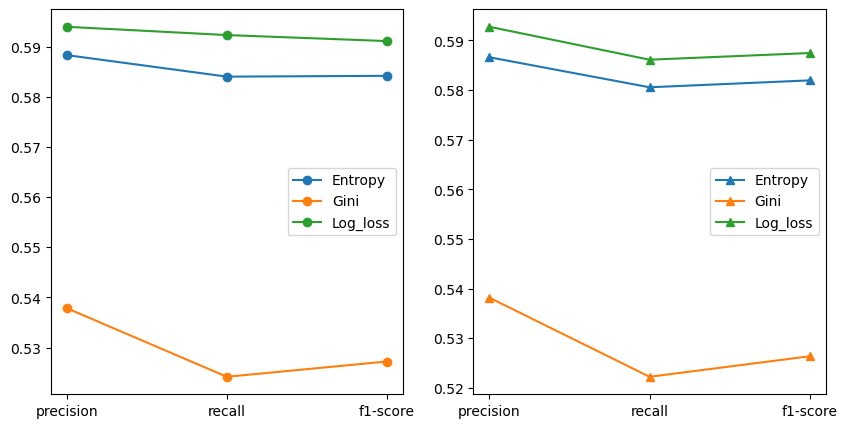

In [49]:
# Plot results
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
x_ticks = list(marco_avg_all["Entropy"].keys())[:3]
fig,axes = plt.subplots(nrows = 1, ncols = 2,
                      figsize = (10,5))
for type in criterions:
    axes[0].plot(x_ticks,
                   np.array([i for i in marco_avg_all[type].values()])[:3],
                   marker = 'o',
                   label = type)
    axes[1].plot(x_ticks,
                   np.array([i for i in weighted_avg_all[type].values()])[:3],
                   marker = "^",
                   label = type)
axes[0].legend(frameon = True)
axes[1].legend(frameon = True)
plt.show()


## 3. Task 3: Evaluating the performances of model by Cross Validation
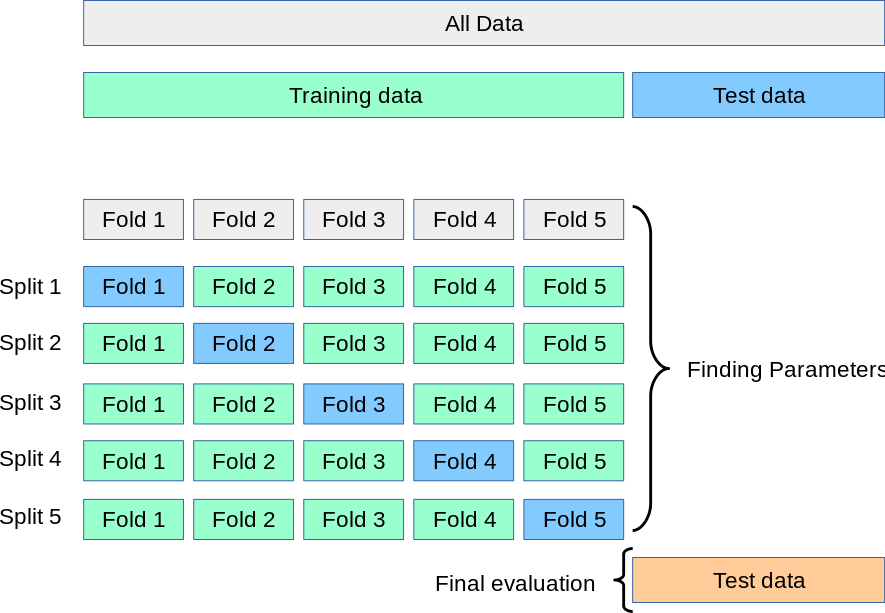

-   Define an evaluate function to compute the accuracy sores on each split step. 
-   Each step will have its own accuracy sore.
-   Number of split step equal to the number of folds 
-   We can repeat this step to get the stability of the accuracy score.

In [50]:
models = [DecisionTreeClassifier(criterion = "entropy",max_depth = 20),
          DecisionTreeClassifier(criterion = 'gini', max_depth = 20),
          DecisionTreeClassifier(criterion = 'log_loss', max_depth= 20)]
criterions = ["Entropy",
              "Gini",
              "Log_loss"]

In [51]:
def evaluate_CrossVal(model,
                         X,y,
                         kfold: int = 10,
                         n_repeats:int  = 5,
                         random_state: int = 1):
    cv = RepeatedStratifiedKFold(n_splits=kfold,
                                 n_repeats=n_repeats,
                                 random_state=random_state)
    return cross_val_score(model,X,y,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=1,
                           error_score='raise')

In [52]:
score_holder = []
for i in range(len(models)):
    print(" Im in step: ",i)
    score_holder.append(evaluate_CrossVal(model=models[i],
                                             X = X, y = y))

 Im in step:  0


 Im in step:  1
 Im in step:  2


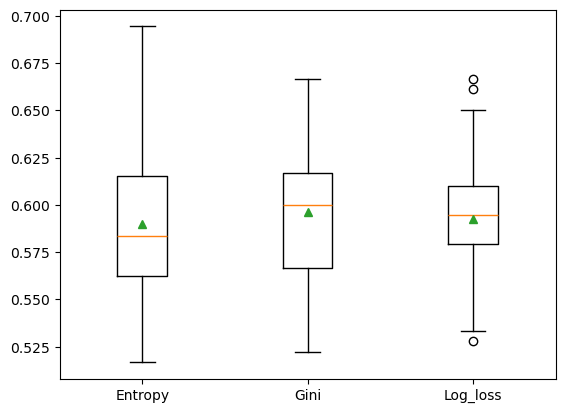

In [53]:
plt.boxplot(score_holder,labels=criterions,showmeans=True)
plt.show()

# Select the best criteria:
-   Splitting criteria: Gini Impurity